In [1]:
#!pip install tensorflow #one-time activity

In [68]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
import cv2
import pickle
import warnings
warnings.filterwarnings("ignore")


from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import DenseNet121

In [69]:
datacsv = pd.read_csv("E:/Data Science Bootcamp/Final Project/Cloths_small_dataset/new_dataset.csv", error_bad_lines=False, warn_bad_lines=False)
categorydata = datacsv[["image","label"]]
print(f"The shape of the dataset is {categorydata.shape}.")
categorydata.head(10)

The shape of the dataset is (4689, 2).


,image,label
0,00003aeb-ace5-43bf-9a0c-dc31a03e9cd2,T-Shirt
1,000d31f6-44b5-4758-8d86-c4fcfb234392,Hoodie
2,001068a8-86c3-4029-a9d9-1e27015e7e64,Polo
3,00143901-a14c-4600-960f-7747b4a3a8cd,Shirt
4,00149032-3dd6-426e-9bc0-d53032536a42,Outwear
5,00208c77-ee58-4b63-bc1a-b9b3aa4f1be0,Outwear
6,0028956e-9962-46f0-ad45-2c42f8a59d94,Outwear
7,002e88c2-e0ce-4a4b-9670-eddc3d99accc,Undershirt
8,002eb5b8-6541-42a3-9596-0d94f7b866ae,Pants
9,00342aff-ba69-4cf2-ae62-e00680e9547a,Not sure


In [71]:
categorydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4689 entries, 0 to 4688
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   4689 non-null   object
 1   label   4689 non-null   object
dtypes: object(2)
memory usage: 73.4+ KB


In [72]:
categorydata.describe()

,image,label
count,4689,4689
unique,4689,20
top,00003aeb-ace5-43bf-9a0c-dc31a03e9cd2,T-Shirt
freq,1,878


In [73]:
dup = categorydata[categorydata.duplicated()].shape[0]
print(f"There is {dup} duplicate entry among {categorydata.shape[0]} entries in this dataset.")

categorydata.drop_duplicates(keep="first",inplace=True)
print(f"After removing duplicate entries there are {categorydata.shape[0]} entries in this dataset.")

There is 0 duplicate entry among 4689 entries in this dataset.
After removing duplicate entries there are 4689 entries in this dataset.


In [74]:
print(f"Missing values of the Dataset :")
categorydata.isna().sum().to_frame()

Missing values of the Dataset :


,0
image,0
label,0


In [75]:
categorydata = categorydata.groupby(["label"], sort=True).size().reset_index(name="Total")
categories = categorydata["label"].tolist()
print(f"The shape of the category data is {categorydata.shape}.")
print(f"There are {len(categories)} categories.")
print(f"The categories are :\n\n{categories}")

The shape of the category data is (20, 2).
There are 20 categories.
The categories are :

['Blazer', 'Blouse', 'Body', 'Dress', 'Hat', 'Hoodie', 'Longsleeve', 'Not sure', 'Other', 'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes', 'Shorts', 'Skip', 'Skirt', 'T-Shirt', 'Top', 'Undershirt']


In [76]:
categorydata.head(10)

,label,Total
0,Blazer,93
1,Blouse,20
2,Body,58
3,Dress,312
4,Hat,148
5,Hoodie,89
6,Longsleeve,598
7,Not sure,201
8,Other,59
9,Outwear,263


In [11]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [77]:
import cv2
image = cv2.imread(r"E:/Data Science Bootcamp/Final Project/Cloths_small_dataset/images/images/000d31f6-44b5-4758-8d86-c4fcfb234392.jpg")

Shape of the sample image : (224, 224, 3)


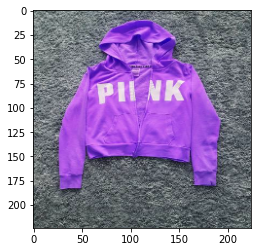

In [78]:
image = cv2.resize(image, (224, 224))
print(f"Shape of the sample image : {image.shape}")
plt.imshow(image)
plt.show()

In [79]:
def traintestsplit(Data):
    
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    for i in range(len(Data)):
        total = Data.iloc[i]["Total"]
        category = Data.iloc[i]["label"]
        data = datacsv[datacsv["label"] == category]
        train_limit = int((80*total/100))
        train_data = train_data.append(data.iloc[0:train_limit-1])
        test_data = test_data.append(data.iloc[train_limit:])
    
    return train_data, test_data

In [80]:
train_data, test_data = traintestsplit(categorydata)

print(f"Shape of the training dataset is {train_data.shape}.")
train_data.head()

Shape of the training dataset is (3722, 2).


,image,label
22,00b8048d-635e-4e56-b182-071fb24eea32,Blazer
40,01a54355-b591-45e9-a248-175f483369cf,Blazer
84,03c6360d-734d-435b-92a8-6788b7b32d78,Blazer
144,06aaacf1-bade-43fc-89de-5d61b7c057f1,Blazer
200,094a6288-3fe1-4422-9912-c2f2704fe067,Blazer


In [81]:
print(f"Shape of the testing dataset is {test_data.shape}.")
test_data.head()

Shape of the testing dataset is (947, 2).


,image,label
3604,ad19b17f-66d9-4f5b-8a90-9539f0311806,Blazer
3697,b1d65578-ec57-4493-bd96-c26ad1e43a78,Blazer
3725,b33e2434-ea6b-4522-b58f-298232345ee5,Blazer
3734,b3af036d-e9d3-43fa-a32d-e3e03b6150bf,Blazer
3750,b4ac2cc0-22f0-4659-82c3-835fa1347660,Blazer


In [82]:
def resnetmodel(height, width):
    model = ResNet50(weights="imagenet", include_top=False, input_shape = (height, width, 3))
    model.trainable = False
    output = layers.GlobalMaxPooling2D()(model.outputs)
    model = Model(inputs=model.inputs, outputs=output)
    model.summary()
    return model

In [83]:
model = resnetmodel(image.shape[0], image.shape[1])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [84]:
print(f"Shape of sample image before expanding dimension : {image.shape}")
image =  np.expand_dims(image, axis = 0) 
print(f"Shape of sample image after expanding dimension : {image.shape}")

Shape of sample image before expanding dimension : (224, 224, 3)
Shape of sample image after expanding dimension : (1, 224, 224, 3)


In [85]:
def getfeaturevector(model, image):
    featurevector = model.predict(image)
    featurevector = featurevector.flatten()
    return featurevector

featurevector = getfeaturevector(model, image)
print(f"Shape of the feature vector of the sample image : {featurevector.shape}")

1/1 [==============================] - 2s 2s/step
Shape of the feature vector of the sample image : (14336,)


In [86]:
def generatefeatures(model, data):
    image_labels = []
    image_features = []
    image_ids = []
    image_path = r"E:/Data Science Bootcamp/Final Project/Cloths_small_dataset/images/images/"
    
    for index, row in data.iterrows():
        imageid = row["image"]
        #print(imageid)
        image_ids.append(imageid)
        imagelabel = row["label"]
        #print(imagelabel)
        image_labels.append(imagelabel)
        image = cv2.imread(image_path + str(imageid) + ".jpg")
        #print(image)
        image = cv2.resize(image, (224, 224))
        image = np.expand_dims(image, axis = 0) 
        featurevector = getfeaturevector(model, image)
        image_features.append(featurevector)

    return np.array(image_features), image_labels, image_ids

In [87]:
train_features, train_labels , train_ids = generatefeatures(model, train_data)
test_features, test_labels, test_ids = generatefeatures(model, test_data)

1/1 [==============================] - 2s 2s/step


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [88]:
def loadfrompickle(picklefile):
    file = open(picklefile,"rb")
    pickledata = pickle.load(file)
    file.close()
    return pickledata

def saveinpickle(data, picklefile):
    file = open(picklefile,"wb")
    pickle.dump(data,file)
    file.close()


print(f"Saving features in pickle files for further usage in recommender engine.")    
saveinpickle([train_features, train_labels , train_ids], "resnet_train")
saveinpickle([test_features, test_labels, test_ids], "resnet_test")

Saving features in pickle files for further usage in recommender engine.


In [104]:
def showimage(testid, imagelabel):
    imagepath = "E:/Data Science Bootcamp/Final Project/Cloths_small_dataset/images/images/"
    image = cv2.imread(imagepath + str(testid) + ".jpg")
    plt.figure()
    plt.imshow(image)
    plt.title(f" {imagelabel} :\n")  
    plt.show()
    
    
def showrecommendations(trainindex):
    ids = []
    for index in trainindex:
        imagepath = "E:/Data Science Bootcamp/Final Project/Cloths_small_dataset/images/images/"
        ids.append(train_ids[index])
        
    fig, axs = plt.subplots(1, 5, figsize=(20,8))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        image = cv2.imread(imagepath + str(ids[i]) + ".jpg")
        plt.imshow(image)
        plt.title(f"Recommended Image No. {i+1}\n")
        plt.title(f"Similar Products\n")
        

def getpredictedresult(trainindex, trainsize, trainlabels):
    result = {}
    for index in trainindex:
        classid  = trainlabels[index]
        # print(classId)
        if(classid not in result):
            result[classid] = 0
        result[classid]+=1
    return max(result, key=result.get)


def KNNmodel(trainfeatures, trainlabels, k, testfeatures, testlabels):
    truelabels = []
    predictedlabels = [] 
    a = np.linalg.norm(testfeatures, axis=1, ord=2)
    b = np.linalg.norm(trainfeatures, axis=1, ord=2)
    a = a.reshape(len(testfeatures),1)
    b = b.reshape(1,len(trainfeatures))
    c = np.matmul(a,b)
    distancematrix =  np.dot(testfeatures, trainfeatures.T)/c
    # for i in range(3,8):
    imgids = [10, 50, 100, 200, 300, 370]
    for i in imgids:
        testclasslabel = test_labels[i]
        truelabels.append(testclasslabel)
        #print(truelabels)
        showimage(test_ids[i], testclasslabel)
        traindistance = distancematrix[i]
        trainindex = traindistance.argsort()[-k:]
        showrecommendations(trainindex)
        result = getpredictedresult(trainindex, len(trainfeatures), trainlabels)
        predictedlabels.append(result)    
    
    return truelabels, predictedlabels

In [105]:
def loadtrainfeatures(modelname):
    trainset = loadfrompickle(modelname + "_train")
    return trainset[0], trainset[1], trainset[2]

def loadtestfeatures(modelname):
    testset = loadfrompickle(modelname + "_test")
    return testset[0], testset[1], testset[2]


print(f"Loading features and labels from pickle files")
trainfeatures, trainlabels, trainids = loadtrainfeatures("./resnet")
testfeatures, testlabels, testids = loadtestfeatures("./resnet")

Loading features and labels from pickle files


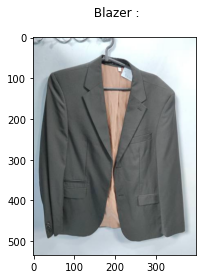

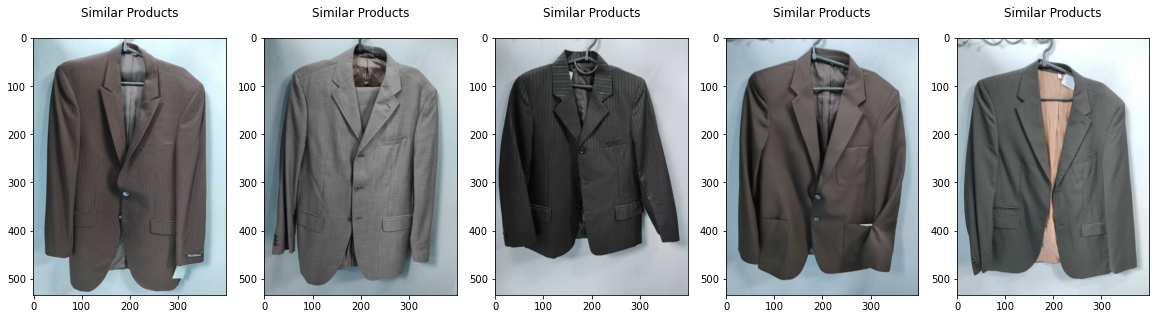

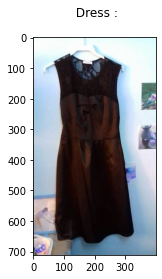

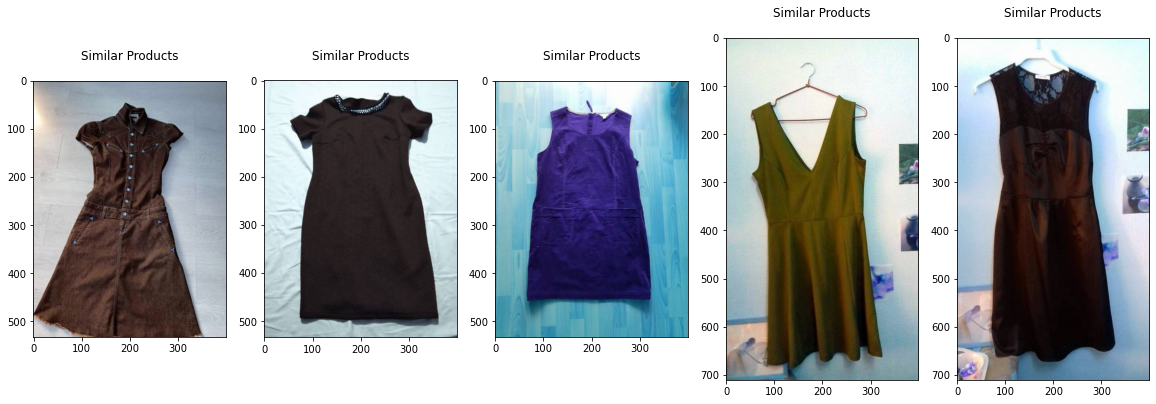

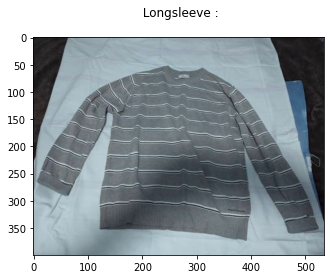

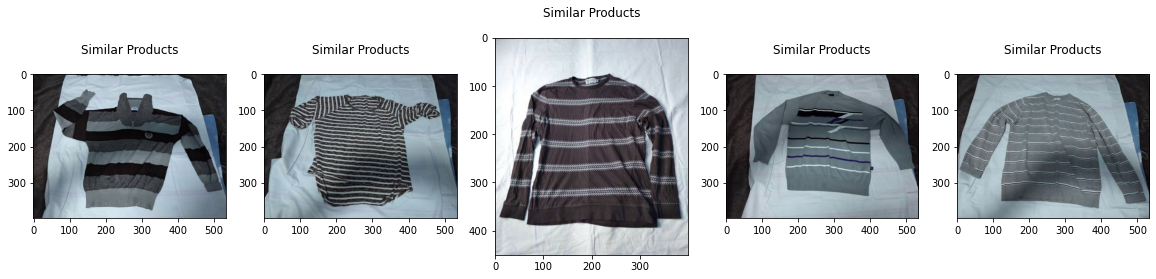

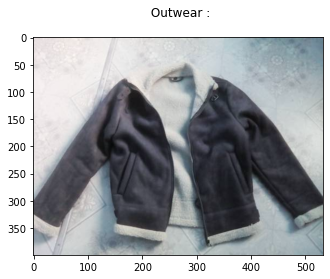

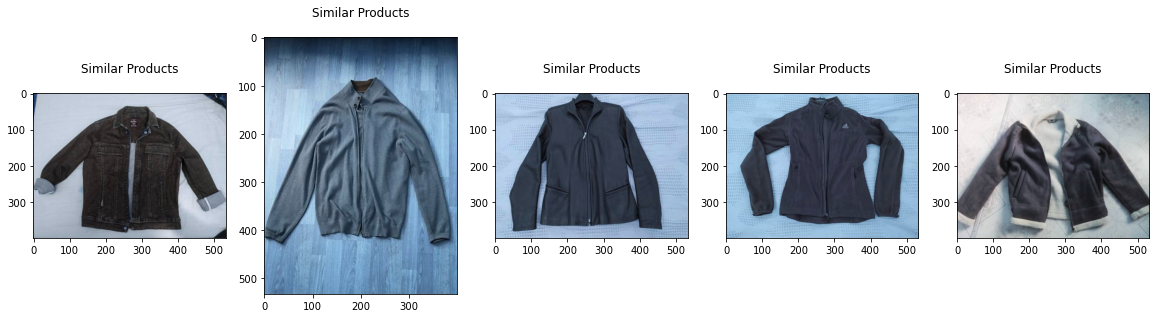

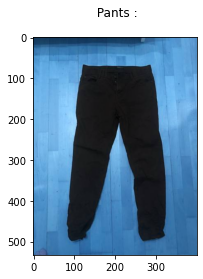

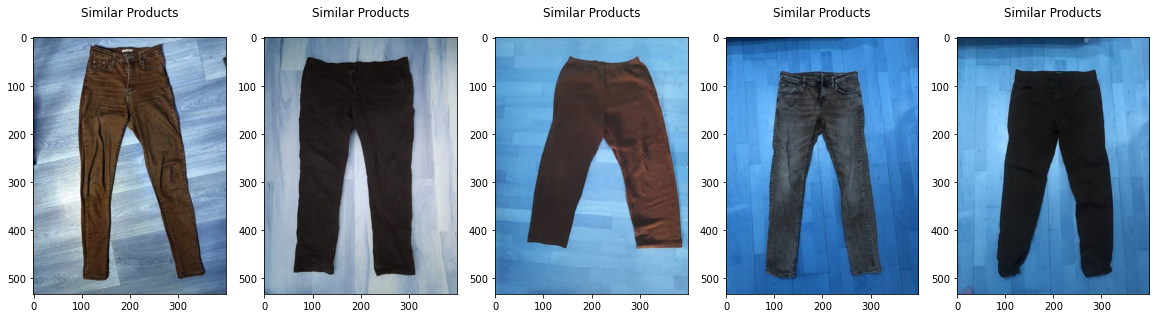

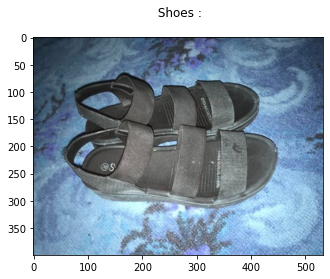

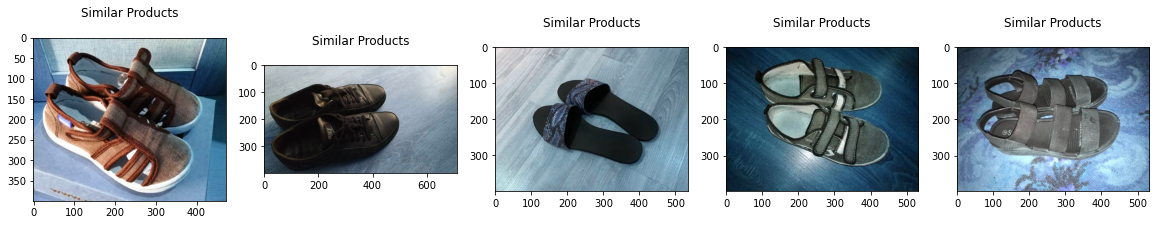

In [106]:
truelabels, predictedlabels = KNNmodel(trainfeatures, trainlabels, 5, testfeatures, testlabels)